# Chapter 9: Convolutional Neural Networks

When matrix multiplications in feed-forward neural networks are replaced with convolutions, we can save a lot of connections and therefore computation. These are applicable whenever you have a grid like structure in your input that you would like to exploit.

### Convolution 

Convolution is an important operation in deep learning. You can think of convolution as an operation which takes a signal and a kernel as input and produces an output. The signal is convolved with the kernel (meaning slided over and multiplied element-wise) and an output is produced. This can be done on 1D signal or 2D images. 

One can think of convolution as a density function that captures the local wiggle around a signal. Let's say you have position of a spaceship, but it has some local noise attached to it. Ideally, you would want to some invariant property that is global in nature that can capture this local wiggleness. The learned kernel (sometimes also called weight function) can be convolved with every point in time to get an aggragated version of the signal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
function = [10,50,60,10,20,40,30]

In [3]:
kernel = [0.33,0.33,0.33]

In [4]:
np.convolve(function, kernel)

array([  3.3,  19.8,  39.6,  39.6,  29.7,  23.1,  29.7,  23.1,   9.9])

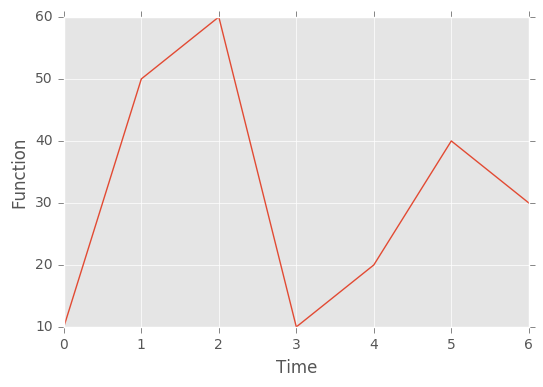

In [5]:
plt.plot(function)
plt.ylabel('Function')
plt.xlabel('Time')

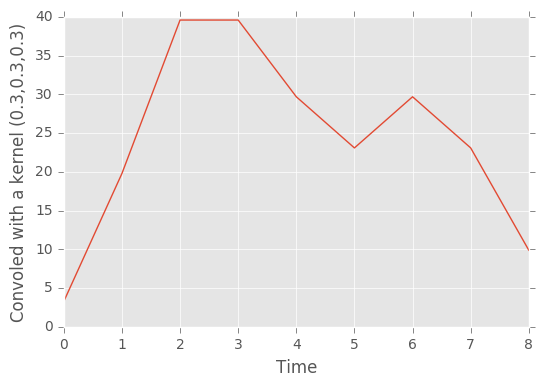

In [6]:
plt.plot(np.convolve(function, kernel))
plt.ylabel('Convoled with a kernel (0.3,0.3,0.3)')
plt.xlabel('Time')

### Convolution on Images

Images have properties that are local in nature, but globally they show a lot of variance. We can learn certain filters, for example, here is a mean filter, that blurs the image. This operation saves a lot of computational resources because it is same operation we are doing at each part of the input image. The book actually digs a little more deeper into the computational efficiency of convolutions.

In [14]:
from skimage.io import imread
import urllib
from skimage import img_as_float

In [15]:
i = imread(urllib.urlopen('https://upload.wikimedia.org/wikipedia/en/2/24/Lenna.png?1486842310500'), 
           flatten= True, mode= 'F')

In [16]:
i.shape

(512, 512)

In [17]:
i = img_as_float(i)

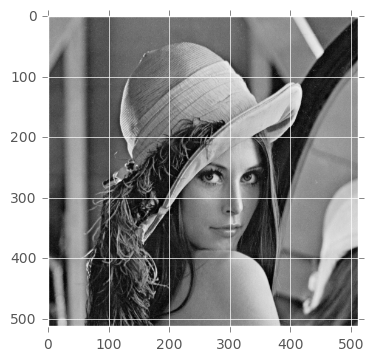

In [18]:
plt.imshow(i, cmap='gray')

In [20]:
from scipy.signal import convolve2d

In [50]:
mean_filter = np.array([[0.03,0.03,0.03],[0.03,0.03,0.03],[0.03,0.03,0.03]])

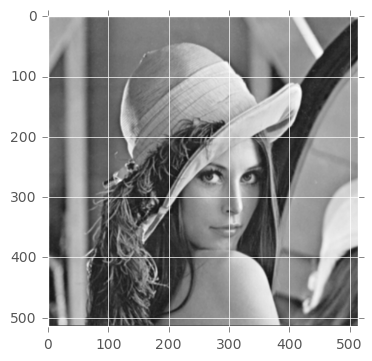

In [51]:
plt.imshow(convolve2d(i,mean_filter), cmap='gray')

## Why convolutional networks?

At a higher level, convolutional networks offer three specific advantages over fully-connected neural networks.

* Sparse interactions
* Parameter Sharing
* Equivalent representations


#### Sparse interactions

Instead of connecting every input neuron to a hidden neuron in the hidden layer, a hidden layer in ConvNet is only connected to a local region in the previous layer. The logical reason behind is surprisingly simple, images have properties that are local in nature and it is rather a waste of computational space trying to connect everything with everything else. As you dive deep into the networks, the receptive field of a neuron increases.

#### Parameter Sharing

As you slide the kernel along the image, you make a naive assumption that the kernel you learned at one part of image is applicable everywhere. So, you end up sharing the learned filter. You want your operations to be translation invariant, and sharing parameters across the image would be able to do that for you. In addition to that, it will save a lot of computation by reducing the weights.

**Note**: Sometimes you don't want to share the weights (think of some images where they have properties that are very local and not moving anywhere). In that case, this assumption of weight sharing does not hold.

For example, look at the parameters of the small network below.

In [27]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation

Using TensorFlow backend.


In [28]:
model = Sequential()
model.add(Convolution2D(6, 5, 5, border_mode='valid', input_shape = (32, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation("sigmoid"))
model.add(Convolution2D(6, 5, 5, border_mode='valid', input_shape = (32, 32, 1)))

In [29]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 28, 28, 6)     156         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 6)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 14, 14, 6)     0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 10, 10, 6)     906         activation_1[0][0]               
Total params: 1062
________________________________________________________________________

There is a little caveat here. I am asking Keras not to pad with any zeros but this configuration is not possible because of the this painful formula. 

Filter output width = (W-F+2P)/(S+1)

In [30]:
32 - 5 / 2.0

29.5

I am guessing that Keras pads the input with a couple of zeros to make this convolution possible.

In [31]:
32 - 5 + 2 / 2.0

28.0

But the main goal of defining the small model here is to show sparse connectivity. In this model, the first layer has 156 learnable parameters. 

In [32]:
6 * 5 * 5 + 6

156

What if instead of sparse connections, everything is connected to everything else?

In [33]:
(6*6*6)*(32*32*1)

221184

We have to learn that many parameters if we were to not use sparse connections and parameter sharing, that is clearly a large number and therefore computationally very expensive.

#### Equivalence 

This weight sharing allows ConvNets to be equivariant to translation. You can switch the order of convolution operation, and translation operation but you end up with the same result.

## Operations in ConvNets

Typically, we have three kinds of operations that are common among most popular networks.

* Convolution
* Activation
* Pooling function

#### Pooling:

* Pooling is an operation that replaces the output of a network at a certain location with summary statistic of the nearby inputs. The intuition behind pooling is to make the network become approximately invariant with small translations in the input.
* Maxpooling is done over a rectangular grid of numbers, the maximum of the grid is selected as pooled output. This reduces the width and height of a particular filter, but does not change the depth.
* One can also do pooling over learned filters. 
* Pooling improves the computational efficiency of the network.
* One certain type of pooling called MaxOut pooling tends to make the network rotation invariant.!

In [34]:
from scipy.ndimage.filters import maximum_filter

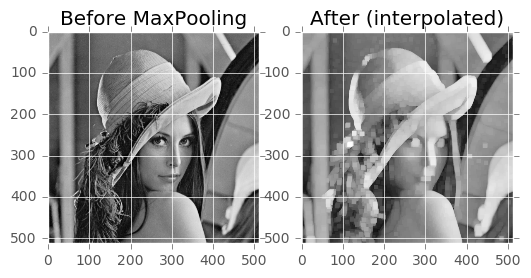

In [45]:
fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.imshow(i, cmap='gray')
a.set_title('Before MaxPooling')
b=fig.add_subplot(1,2,2)
plt.imshow(maximum_filter(i, size=(10,10)), cmap='gray')
b.set_title('After (interpolated)')

Pooling puts a constraint on the input size. Now a days, pooling layers are being replaced by fully convolutional layers.

## Convolution and Pooling as Strong Priors

* We can intrepret convnets similar to fully connected networks with a strong prior. We are asking the ConvNet to be invariant to local transformations (pooling) and capture the local invariance (convolution). This could be intrepreted a strong prior (with very low entropy) on the fully connected network.
* Can very long range dependencies be captured by ConvNets? Looks like they can, with sufficient depth. Otherwise, the receptive field of the output layer might not be good enough to capture all the information.

## Variants of Convolutional Networks

#### Unshared Convolutions

Sometimes, you don't want to share parameters in the network. These kind of networks with no shared weights are called locally-connected. These are not fully-connected layers, but only connected to a local region around the input. You learn a different kind of filter at different positions in the input space. This is computationally expensive.

#### Tiled Convolutions

This is kind of a trade-off between having convolutions and local connections. In tiled convolutions, the weights are shared not on the complete input but a certain local part of it, they are tiled across the input. This is a strange arrangement, I don't know why one would want this.

## Structured Outputs

ConvNets can also be used to output a high-dimensional structured object. These can be intrepreted as probability distributions over all the classes.

**Eg:** Pixel labelling

Input (image) to Output (probability distribution over classes)

## Data Types

Dimension | Example | Method
--- | --- | ---
1D | Audio Waveform | Convolution in time
2D | Audio Fourier Spectrograh | 2D Convolution over image
3D | Medical Imaging, Scans | Convolution over input
Mult-channel | Animation, Color Image, Color Video | Convolution over input

## A little bit more:

* Efficient ways of computing convolutions is still an active area of research.
* Does ConvNets need a lot of numeric capacity that is being used by a float32 point? Can we do better?
* Layer wise pretraining to make them converge faster!
* There is a lot of inspiration from neuro-science, the 'V1' region in brain is experimentally proved to learn something akin to Gabor filters, edge detectors.
* Brain can do a lot more than naive convolutions, it is known that brain does not receive a very high resolution input. But, still it manages to extrapolate the resolution and do pretty well!
* Long road ahead!
* Nature seems to have figured out everything before we did.